# 1. Setup

## 1.1 Import libraries and reading data

In [129]:
import yaml
with open ("/Users/zoe/Documents/Bank-account-fraud/params.yaml") as p:
    params = yaml.safe_load(p)
params

{'data_location': '/Users/zoe/Documents/Bank-account-fraud/data/Base_backup.csv',
 'output_location': '/Users/zoe/Documents/Bank-account-fraud/output'}

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')

from pylab import rcParams

import seaborn as sns
sns.set_style('whitegrid')
my_palette = sns.color_palette("Paired")

from scipy.stats import chi2_contingency, pearsonr

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2

pd.set_option('display.max_columns', 500)

import warnings as wr
wr.filterwarnings('ignore')


In [183]:
df_base = pd.read_csv(params['data_location'])
df = df_base.copy()

## 1.2 Drop features with no variance

In [15]:
constant_feature =[]
for x in df.columns:
    if df[x].nunique() == 1:
        constant_feature.append(x)

print("Constant features:", constant_feature)

Constant features: ['device_fraud_count']


In [16]:
df = drop_unnecessary_columns(df, df[constant_feature])

## 1.3 Train test split

In [184]:
y = df["fraud_bool"]
X = df.drop(columns=['fraud_bool'], axis = 1)

In [185]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [159]:
X_train.shape

(800000, 31)

In [161]:
y_train.shape

(800000,)

## 1.4 Helper functions

In [132]:
# split categorical and numerical features
def split_num_cat(df):
    """
    Function to split columns into two, one having categorical features and another having numerical feautures
    Parameters
    ----------
    df : dataframe
            pass in full dataframe
    ----------
    Returns: 
        a list of categorical features
        a list of numerical features
    """
    categorical_features = []
    numerical_features = []

    for x in df.columns: 
        if df[x].nunique() > 12:
            numerical_features.append(x)
        elif df[x].nunique() >=2:
            categorical_features.append(x)

    if 'fraud_bool' in categorical_features:
        categorical_features.remove('fraud_bool')
    
    return categorical_features, numerical_features

# def drop_unnecessary_columns(df, column_name):
#     """
#     Function to delete the list of columns 
#     Parameters
#     ----------
#     df : dataframe
#             pass in full dataframe
#     column_name : list
#             pass in list of full column
#     ----------
#     Returns: Dataframe
#     """
#     df = df.drop(column_name, axis=1)
#     return df

In [133]:
categorical_features, numerical_features = split_num_cat(df)
print('Categorical features:', categorical_features)
print('Numerical features:', numerical_features)

Categorical features: ['income', 'customer_age', 'payment_type', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'month']
Numerical features: ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes']


# 2. Handle missing values¶

XGBoost supports missing values by default. In tree algorithms, branch directions for missing values are learned during training. And the gblinear booster treats missing values as zeros.

We still choose to handle missing values in case of we are using any other types of models. 
Also for features with high percentage of missing values, we choose to add an additional column to indicate where the value is missing, so the model can still learn from missing values. 

In [134]:
# Get names of columns with missing values
missing_value_val = [x for x in df.columns if (df[x].min() == -1)]

print("Features with missing values represented by -1:")
print(missing_value_val)

# Replace all missing value (-1) with NaN
df[missing_value_val] = df[missing_value_val].replace(-1, np.nan)

Features with missing values represented by -1:
['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']


In [135]:
print(df[missing_value_val].mean())

prev_address_months_count       60.719967
current_address_months_count    86.962058
bank_months_count               14.862618
session_length_in_minutes        7.562193
device_distinct_emails_8w        1.019037
dtype: float64


In [136]:
print(df[missing_value_val].median())

prev_address_months_count       34.000000
current_address_months_count    53.000000
bank_months_count               15.000000
session_length_in_minutes        5.122832
device_distinct_emails_8w        1.000000
dtype: float64


device_distinct_emails_8w: with median/mean/mode all ook, all = 1

session_length_in_minutes: with median, skewed to the right

current_address_months_count: with median

prev_address_months_count: use median as the data is skewed to the right

bank_months_count: use mode , as the data is not normally distributed and has a multimodal distribution, and there is a divergance between fraud/non-fruad distribution.

In [137]:
# Calculate the percentage of missing values 
missing_vals = pd.DataFrame()

for feature in missing_value_val:
    missing_vals_col = df.groupby('fraud_bool')[feature].apply(lambda x: round(x.isna().sum()/len(x) * 100, 2))
    missing_vals[feature] = missing_vals_col
    
missing_vals = pd.DataFrame(missing_vals.T.stack())

missing_vals.reset_index(inplace=True)
missing_vals.rename(columns={'level_0': 'feature', 0: 'missing_vals_percentage'}, inplace=True)

print(missing_vals)

                        feature  fraud_bool  missing_vals_percentage
0     prev_address_months_count           0                    71.06
1     prev_address_months_count           1                    91.89
2  current_address_months_count           0                     0.43
3  current_address_months_count           1                     0.13
4             bank_months_count           0                    25.23
5             bank_months_count           1                    37.54
6     session_length_in_minutes           0                     0.20
7     session_length_in_minutes           1                     0.16
8     device_distinct_emails_8w           0                     0.04
9     device_distinct_emails_8w           1                     0.04


In [272]:
df_train_imputed = X_train.copy()
df_test_imputed = X_test.copy()

In [273]:
# For features with missing_vals_percentage < 1, impute missing values with the median of the group 
columns_to_impute = ['current_address_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

medians = {}
for column in columns_to_impute:
    medians[column] = df_train_imputed[column].median()

for column in columns_to_impute:
    df_train_imputed[column] = df_train_imputed[column].fillna(medians[column])
    df_test_imputed[column] = df_test_imputed[column].fillna(medians[column])

# Verify no more null values
print((df_train_imputed[columns_to_impute].isna()).sum())
print((df_test_imputed[columns_to_impute].isna()).sum())

current_address_months_count    0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64
current_address_months_count    0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64


In [274]:
m1 = df_train_imputed.groupby('month')['bank_months_count'].apply(
    lambda x: x.median()
)
display(m1)

month
0    10.0
1     5.0
2     5.0
3     3.0
4     5.0
5     5.0
6     5.0
7     2.0
Name: bank_months_count, dtype: float64

In [141]:
df_imputation.isna().sum()

fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           712920
current_address_months_count             0
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                        0
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   253635
has_other_cards                          0
proposed_cr

In [142]:
# For bank_months_count, use group based imputation with the median of the group per income bucket because the data has a multimodal distribution

# add additional column to indicate where missing value is
df_imputation['bank_months_count' + '_was_missing'] = df_imputation['bank_months_count'].isna().astype(int)
df_imputation['bank_months_count'] = df_imputation.groupby('month')['bank_months_count'].transform(
        lambda x: x.fillna(x.median())
    )

In [143]:
df_imputation['current_address_months_count'].describe()

count    1000000.000000
mean          86.817583
std           88.248728
min            0.000000
25%           20.000000
50%           53.000000
75%          130.000000
max          428.000000
Name: current_address_months_count, dtype: float64

Longer current address durations correlate with higher missing values in months_in_previous_address, it indicates the missing values are likely not missing at random. Since the missing value correlates with current_address_months_count, use its value as a condition for imputation.

In [144]:
df_imputation['current_address_bucket'] = pd.cut(
    df_imputation['current_address_months_count'], 12
    # bins=[0, 6, 12, 36, 60, 120, df_imputation['current_address_months_count'].max()]
)
m = df_imputation.groupby('current_address_bucket')['prev_address_months_count'].apply(
    lambda x: x.median()
)
display(m)

current_address_bucket
(-0.428, 35.667]       33.0
(35.667, 71.333]       33.0
(71.333, 107.0]        51.0
(107.0, 142.667]       55.0
(142.667, 178.333]     57.0
(178.333, 214.0]       60.0
(214.0, 249.667]       72.0
(249.667, 285.333]     69.0
(285.333, 321.0]       84.0
(321.0, 356.667]       82.0
(356.667, 392.333]     78.0
(392.333, 428.0]      114.0
Name: prev_address_months_count, dtype: float64

In [145]:
df_imputation['prev_address_months_count' + '_was_missing'] = df_imputation['prev_address_months_count'].isna().astype(int)

# Impute within each bucket
df_imputation['prev_address_months_count'] = df_imputation.groupby('current_address_bucket')['prev_address_months_count'].transform(
    lambda x: x.fillna(x.median())
)

In [146]:
# Verify results
print("Count of null values after imputation:")
print((df_imputation[missing_value_val].isna()).sum())

counts = (
    df_imputation.groupby('fraud_bool')[['bank_months_count_was_missing', 'prev_address_months_count_was_missing']]
    .apply(lambda group: group.apply(pd.Series.value_counts))
)

print("Counts in '_was_missing' columns grouped by 'fraud_bool':")
print(counts)

Count of null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64
Counts in '_was_missing' columns grouped by 'fraud_bool':
              bank_months_count_was_missing  \
fraud_bool                                    
0          0                         739476   
           1                         249495   
1          0                           6889   
           1                           4140   

              prev_address_months_count_was_missing  
fraud_bool                                           
0          0                                 286185  
           1                                 702786  
1          0                                    895  
           1                                  10134  


In [147]:
df_imputation.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,51.534704,36.892551,5.000000e+00,33.000000,51.000000,57.000000,383.000000
current_address_months_count,1000000.0,86.817583,88.248728,0.000000e+00,20.000000,53.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


In [148]:
df_imputed = df_imputation.drop("current_address_bucket", axis=1)

## 3. One-hot encode for categorical features

In [173]:
# One-hot encoding for categorical featuers with dtype as 'object'
object_features = [col for col in x_train.columns if x_train[col].dtypes == 'object']
print(object_features)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [193]:
for i in object_features:
    print(i, '\n', x_train[i].unique(), '\n')

payment_type 
 ['AB' 'AC' 'AA' 'AD' 'AE'] 

employment_status 
 ['CD' 'CB' 'CA' 'CF' 'CE' 'CC' 'CG'] 

housing_status 
 ['BB' 'BC' 'BE' 'BA' 'BD' 'BF' 'BG'] 

source 
 ['INTERNET' 'TELEAPP'] 

device_os 
 ['macintosh' 'linux' 'windows' 'other' 'x11'] 



In [186]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

ohe_X_train = pd.DataFrame(ohe.fit_transform(X_train[object_features]))

ohe_X_test = pd.DataFrame(ohe.transform(X_test[object_features]))

ohe_X_train.index = X_train.index
ohe_X_test.index = X_test.index

ohe_feature_names = ohe.get_feature_names_out(input_features=object_features)
ohe_X_train.columns = ohe_feature_names
ohe_X_test.columns = ohe_feature_names

num_X_train = X_train.drop(object_features, axis=1)
num_X_test = X_test.drop(object_features, axis=1)

X_train = pd.concat([num_X_train, ohe_X_train], axis=1)
# X_train = X_train.drop(object_features, axis=1)
X_test = pd.concat([num_X_test, ohe_X_test], axis=1)
# X_test = X_test.drop(object_features, axis=1)

In [195]:
X_test.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
987231,0.1,0.218119,110,7,20,0.015684,-1.013463,687,1442.159111,6438.768228,3060.149789,9,2,172,0,0,1,28,0,500.0,0,15.611467,1,1,0,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79954,0.1,0.373086,29,7,20,0.024277,19.342285,1230,6236.294791,5484.355709,4760.177409,706,9,128,1,0,1,22,0,200.0,0,5.911984,0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
567130,0.2,0.515218,-1,64,20,0.015865,-1.333985,2045,5302.674495,5521.168702,4970.617404,14,16,7,1,1,1,25,1,200.0,0,4.732999,1,1,0,4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
500891,0.6,0.899345,-1,56,20,0.018821,-1.524424,1260,5401.796610,4411.629738,4831.579015,1,13,96,1,0,1,-1,0,200.0,0,8.210518,1,1,0,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
55399,0.9,0.794648,-1,64,50,0.027359,-1.254528,1643,10657.943300,6073.103673,6376.081608,13,7,85,0,0,1,1,0,200.0,0,5.131610,0,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# 4. Handle outliers 

In [152]:
df_outliers = df_one_hot.copy()

# 5. Scaling

help with unsupervised learning, minimise bias against one variabel 

In [266]:
X_train[numerical_features].describe()

,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,session_length_in_minutes
count,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.493679,16.727529,86.651003,1.024581e+00,8.666942,1572.691783,5664.123809,4768.744070,4856.113352,184.627865,9.502435,131.055336,10.847309,7.548144
std,0.289083,44.073072,88.428548,5.384940e+00,20.255749,1005.553072,3010.204130,1478.809582,919.994441,459.934773,5.033803,69.742814,12.118281,8.042752
min,0.000001,-1.000000,-1.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1320.283991,2825.748405,0.000000,0.000000,-169.000000,-1.000000,-1.000000
25%,0.225180,-1.000000,19.000000,7.183933e-03,-1.181387,894.000000,3435.962936,3592.988203,4268.319057,1.000000,6.000000,83.000000,-1.000000,3.102776
50%,0.492253,-1.000000,52.000000,1.517071e-02,-0.830680,1263.000000,5317.126477,4749.005380,4913.667485,9.000000,9.000000,122.000000,5.000000,5.114818
75%,0.755595,12.000000,130.000000,2.632796e-02,4.984334,1943.000000,7681.772107,5750.629217,5487.721416,25.000000,13.000000,178.000000,25.000000,8.870898
max,0.999999,381.000000,428.000000,7.845690e+01,112.956928,6700.000000,16640.749743,9506.896596,6994.764201,2385.000000,39.000000,386.000000,32.000000,83.376775


In [270]:
X_scaled = df_imputed.copy()
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

scaled_train = minmax_scaler.fit_transform(X_train[numerical_features])
scaled_test = minmax_scaler.transform(X_test[numerical_features])

for i, feature in enumerate(numerical_features):
    X_train['scaled_' + feature] = scaled_train[:, i]
    X_test['scaled_' + feature] = scaled_test[:, i]

X_train.describe()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,scaled_name_email_similarity,scaled_prev_address_months_count,scaled_current_address_months_count,scaled_days_since_request,scaled_intended_balcon_amount,scaled_zip_count_4w,scaled_velocity_6h,scaled_velocity_24h,scaled_velocity_4w,scaled_bank_branch_count_8w,scaled_date_of_birth_distinct_emails_4w,scaled_credit_risk_score,scaled_bank_months_count,scaled_session_length_in_minutes
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.0,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.562838,0.493679,16.727529,86.651003,33.683575,1.024581e+00,8.666942,1572.691783,5664.123809,4768.744070,4856.113352,184.627865,9.502435,131.055336,0.529831,0.416859,0.889574,10.847309,0.222844,516.355675,0.025276,7.548144,0.576540,1.018345,0.0,3.289231,0.258252,0.370686,0.252069,0.118703,0.000290,0.730457,0.138044,0.037816,0.026511,0.022756,0.043951,0.000464,0.169824,0.260911,0.371921,0.026196,0.169220,0.001677,0.000250,0.992920,0.007080,0.332508,0.053678,0.342805,0.263790,0.007220,0.493679,0.046407,0.204315,0.013059,0.188326,0.234616,0.347071,0.421232,0.487013,0.077412,0.243652,0.540640,0.359009,0.101309
std,0.290284,0.289083,44.073072,88.428548,12.023340,5.384940e+00,20.255749,1005.553072,3010.204130,1478.809582,919.994441,459.934773,5.033803,69.742814,0.499110,0.493039,0.313421,12.118281,0.416155,487.806283,0.156963,8.042752,0.494107,0.180952,0.0,2.209984,0.437674,0.482989,0.434201,0.323438,0.017027,0.443722,0.344946,0.190752,0.160650,0.149126,0.204987,0.021530,0.375478,0.439132,0.483318,0.159719,0.374946,0.040923,0.015809,0.083844,0.083844,0.471112,0.225380,0.474647,0.440687,0.084663,0.289084,0.115375,0.206127,0.068636,0.157648,0.150105,0.179058,0.180638,0.220674,0.192845,0.129072,0.125663,0.367221,0.095319
min,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1320.283991,2825.748405,0.000000,0.000000,-169.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

# Mutual Information

In [47]:
df_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 55 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   fraud_bool                             1000000 non-null  int64  
 1   income                                 1000000 non-null  float64
 2   name_email_similarity                  1000000 non-null  float64
 3   prev_address_months_count              1000000 non-null  float64
 4   current_address_months_count           1000000 non-null  float64
 5   customer_age                           1000000 non-null  int64  
 6   days_since_request                     1000000 non-null  float64
 7   intended_balcon_amount                 1000000 non-null  float64
 8   zip_count_4w                           1000000 non-null  int64  
 9   velocity_6h                            1000000 non-null  float64
 10  velocity_24h                           1000

In [43]:
X = df_one_hot.copy()
y = X.pop("fraud_bool")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [44]:
discrete_features

income                                   False
name_email_similarity                    False
prev_address_months_count                False
current_address_months_count             False
customer_age                              True
days_since_request                       False
intended_balcon_amount                   False
zip_count_4w                              True
velocity_6h                              False
velocity_24h                             False
velocity_4w                              False
bank_branch_count_8w                      True
date_of_birth_distinct_emails_4w          True
credit_risk_score                         True
email_is_free                             True
phone_home_valid                          True
phone_mobile_valid                        True
bank_months_count                        False
has_other_cards                           True
proposed_credit_limit                    False
foreign_request                           True
session_lengt

In [45]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores # show a few features with their MI scores

housing_status_BA                        0.004959
date_of_birth_distinct_emails_4w         0.003106
credit_risk_score                        0.003080
current_address_months_count             0.003007
bank_months_count                        0.002964
device_distinct_emails_8w                0.002809
proposed_credit_limit                    0.002646
customer_age                             0.002596
device_os_windows                        0.002405
income                                   0.002238
prev_address_months_count                0.002059
prev_address_months_count_was_missing    0.001813
has_other_cards                          0.001307
device_os_linux                          0.001246
housing_status_BC                        0.001159
keep_alive_session                       0.001086
device_os_other                          0.001053
payment_type_AC                          0.001007
month                                    0.001004
name_email_similarity                    0.000968


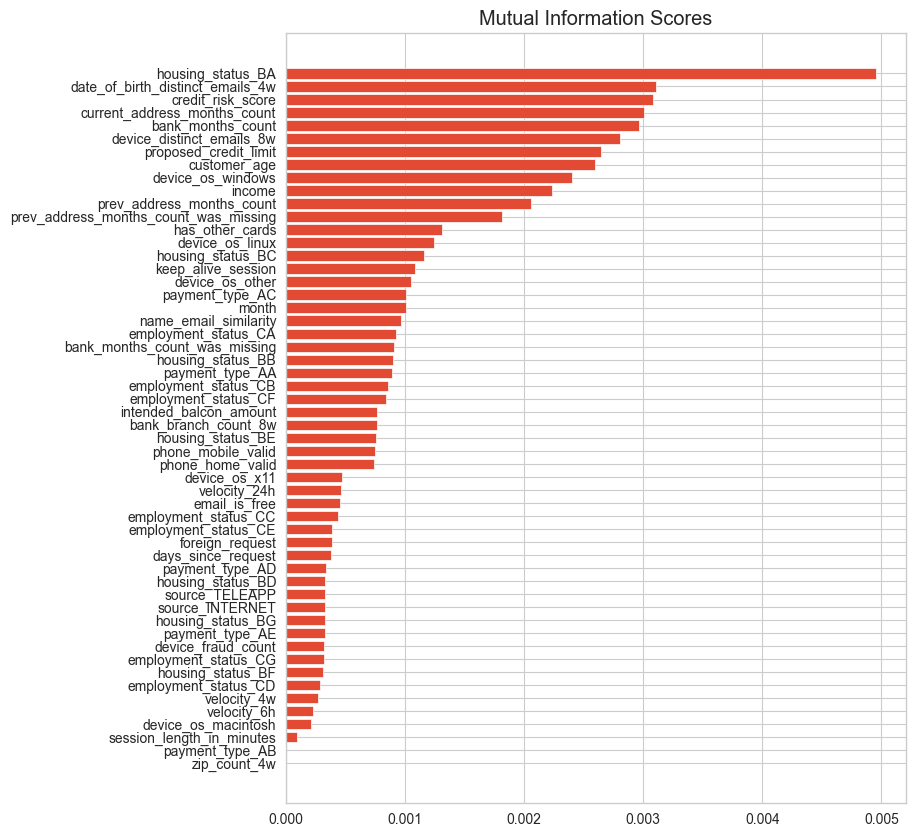

In [49]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 10))
plot_mi_scores(mi_scores)

MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

# Creating Features

Tips on Creating Features

It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

Linear models learn sums and differences naturally, but can't learn anything more complex.
Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.

Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once. 

# Target Encoding

# Maybe useful later... score baseline model

In [42]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex3 import *

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for bank account fraud is recall @5% FPR
    score = cross_val_score(
        # model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


# Prepare data
df = pd.read_csv("../input/fe-course-data/ames.csv")
X = df.copy()
y = X.pop("SalePrice") 

ModuleNotFoundError: No module named 'learntools'

In [ ]:
X_new = X.join([X_1, X_2, X_3, X_4, X_5])
score_dataset(X_new, y)